10s

In [1]:
import os
import time
import csv
import signal
import random
import numpy as np
from tqdm import tqdm

from concurrent.futures import ProcessPoolExecutor, TimeoutError
from rasengan.problems.facility_location_problem import generate_flp
from rasengan.problems.graph_coloring_problem import generate_gcp
from rasengan.problems.k_partition_problem import generate_kpp
from rasengan.problems.job_scheduling_problem import generate_jsp
from rasengan.problems.set_cover_problem import generate_scp
from rasengan.solvers.optimizers import CobylaOptimizer
from rasengan.solvers.qiskit import (
    RasenganSolver,
    DdsimProvider,
)
np.random.seed(0x7f)
random.seed(0x7f)

In [2]:
num_cases = 10

flp_problems_pkg, flp_configs_pkg = generate_flp(num_cases, [(1, 2)], 10, 30)
kpp_problems_pkg, kpp_configs_pkg = generate_kpp(num_cases, [(4, 2, 3)], 1, 20)
jsp_problems_pkg, jsp_configs_pkg = generate_jsp(num_cases, [(2, 2, 3)], 1, 20)
scp_problems_pkg, scp_configs_pkg = generate_scp(num_cases, [(4, 4)])
gcp_problems_pkg, gcp_configs_pkg = generate_gcp(num_cases, [(3, 1)])

In [3]:
ablation_depth_csv_path = "ablation_depth.csv"

problems_pkg = flp_problems_pkg + kpp_problems_pkg + jsp_problems_pkg + scp_problems_pkg + gcp_problems_pkg

metrics_lst = ['depth', 'num_params']
opt_modes = [[0, 0], [1, 0], [1, 1]]
headers = ["pkid", 'method', 'layers'] + metrics_lst

def process_layer(prb, num_layers, opt_mode, metrics_lst):
    opt = CobylaOptimizer(max_iter=300)
    ddsim = DdsimProvider()
    used_solver = RasenganSolver(
        prb_model = prb,
        optimizer = opt,
        provider = ddsim,
        num_layers = num_layers,
        shots = 1024,
        opt_mode = opt_modes[opt_mode],
    )
    metrics = used_solver.circuit_analyze(metrics_lst)
    return metrics

if __name__ == '__main__':
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 # Set timeout duration
    num_complete = 0
    
    with open(f'{ablation_depth_csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count() // 2
    with ProcessPoolExecutor(max_workers=num_processes_cpu) as executor:
        futures = []
        id = 0
        for opt_mode in range(3):
            for pkid, problems in enumerate(problems_pkg):
                for problem in problems:
                    # print(f'process_{id} build')
                    id += 1
                    num_layers = 5
                    future = executor.submit(process_layer, problem, num_layers, opt_mode, metrics_lst)
                    futures.append((future, pkid, opt_mode, num_layers))

        start_time = time.perf_counter()
        for future, pkid, opt_mode, num_layers in tqdm(futures, desc="Evaluating depth across opt_mode"):
            current_time = time.perf_counter()
            remaining_time = max(set_timeout - (current_time - start_time), 0)
            diff = []
            try:
                result = future.result(timeout=remaining_time)
                diff.extend(result)
                # print(f"Task for problem {pkid}, num_layers {num_layers} executed successfully.")
            except MemoryError:
                diff.append('memory_error')
                print(f"Task for problem {pkid}, num_layers {num_layers} encountered a MemoryError.")
            except TimeoutError:
                diff.append('timeout')
                print(f"Task for problem {pkid}, num_layers {num_layers} timed out.")
            finally:
                row = [pkid, opt_mode, num_layers] + diff
                with open(f'{ablation_depth_csv_path}', mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(row)  # Write row immediately
                num_complete += 1
                if num_complete == len(futures):
                    # print(f'Data has been written to {ablation_depth_csv_path}')
                    for process in executor._processes.values():
                        os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {ablation_depth_csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Evaluating depth across opt_mode: 100%|██████████| 150/150 [00:07<00:00, 19.23it/s]


Data has been written to ablation_depth.csv
Time elapsed: 10.79s


In [4]:
import pandas as pd
import numpy as np

ablation_depth_csv_path = "ablation_depth.csv"
df = pd.read_csv(ablation_depth_csv_path)

df_to_modify = df[df['method'] == 2].copy()
df_to_modify['depth'] = df_to_modify['depth'] / df_to_modify['num_params']
df_to_modify['method'] = 3
df = pd.concat([df, df_to_modify], ignore_index=True)
df = df[df['depth'] >= 20]
df = df[(df['num_params'] >= 1)]

grouped_df = df.groupby(['pkid', 'method'], as_index=False).agg({
    "depth": ["mean", "std"],
    "num_params": ["mean", "std"],
})

values = ["depth", 'num_params']

In [5]:
import pandas as pd
import numpy as np

ablation_depth_csv_path = "ablation_depth.csv"
df = pd.read_csv(ablation_depth_csv_path)

df_to_modify = df[df['method'] == 2].copy()
df_to_modify['depth'] = df_to_modify['depth'] / df_to_modify['num_params']
df_to_modify['method'] = 3
df = pd.concat([df, df_to_modify], ignore_index=True)
df = df[df['depth'] >= 20]
df = df[(df['num_params'] >= 1)]

grouped_df = df.groupby(['pkid', 'method'], as_index=False).agg({
    "depth": ["mean", "std"],
    "num_params": ["mean", "std"],
})

values = ["depth", 'num_params']

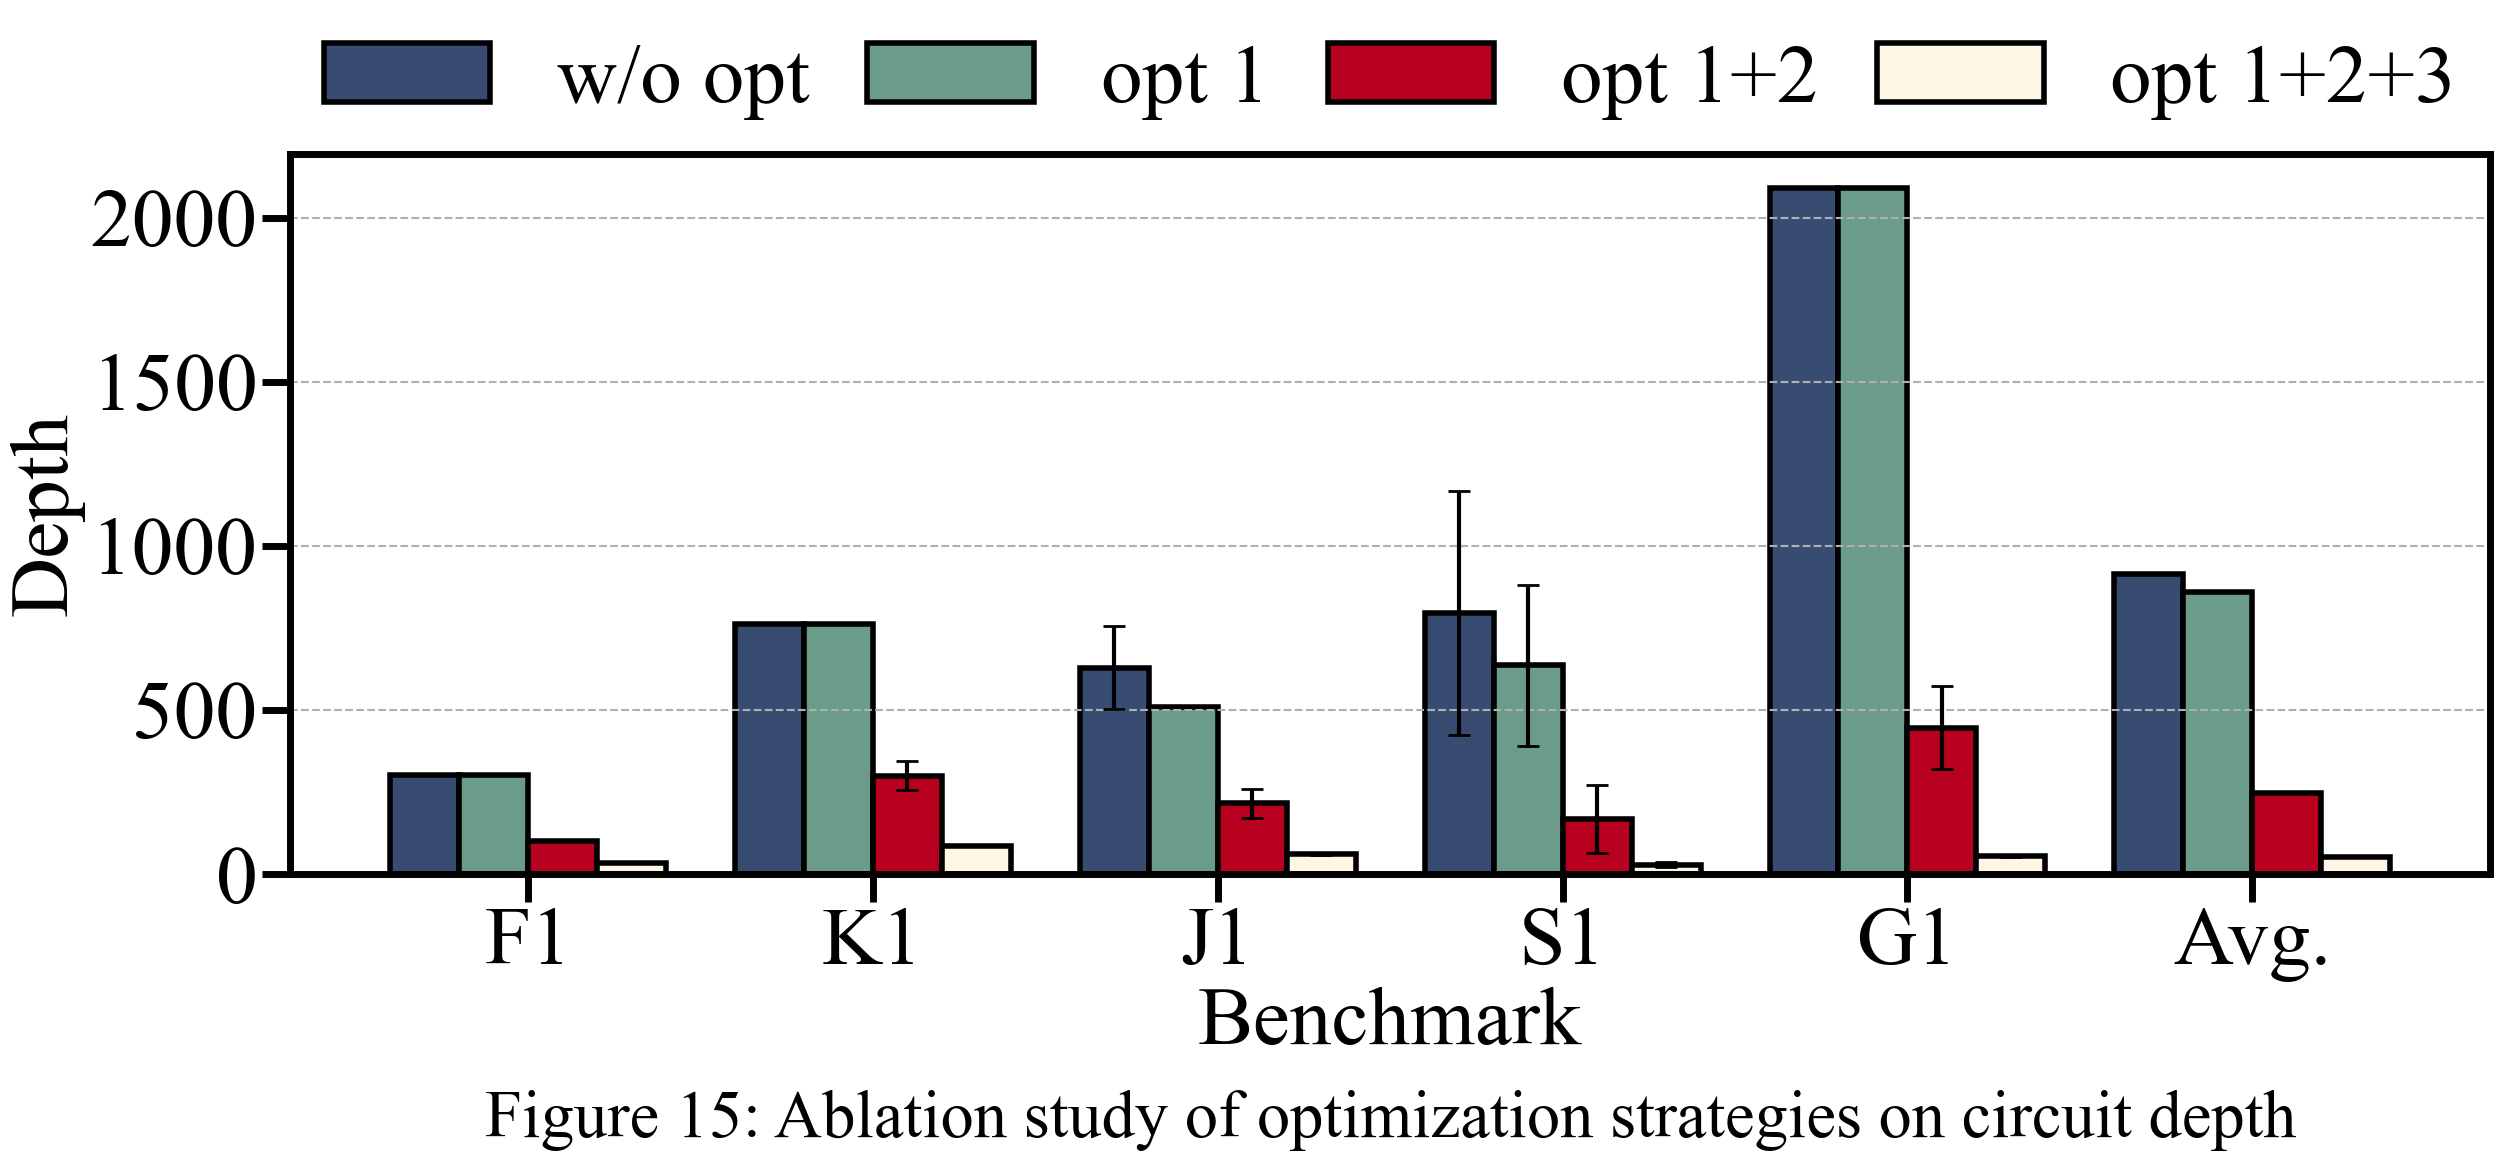

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    'lines.markersize': 35,
    'lines.markeredgewidth': 4,
    'markers.fillstyle': 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

scale = 1
fig = plt.figure(figsize=(22 * scale, 12 * scale))
ax = plt.axes((0, 0, 1, 0.6))

bar_width = 0.2
colors = ['#384B70', '#6A9C89', '#B8001F', '#FFF5E4']
labels = ['w/o opt', 'opt 1', 'opt 1+2', 'opt 1+2+3']
error_params = dict(elinewidth=3, ecolor='black', capsize=8, capthick=2)

for idx in range(4):
    data = grouped_df[grouped_df.method == idx]
    x = np.arange(len(data.pkid) + 1)
    y = data['depth']['mean'].to_list()
    y.append(np.mean(y))
    err = data['depth']['std'].to_list()
    err.append(0)

    ax.bar(
        x + idx * bar_width - bar_width,
        y,
        bar_width,
        color=colors[idx],
        yerr=err,
        error_kw=error_params,
        edgecolor="black",
        label=labels[idx],
        linewidth=4,
    )

ax.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(['F1', 'K1', 'J1', 'S1', 'G1', 'Avg.'])
ax.set_xlabel('Benchmark')
ax.set_ylabel('Depth')
ax.set_yticks([0, 500, 1000, 1500, 2000])

ax.legend(
    loc='upper left',
    ncol=4,
    frameon=False,
    bbox_to_anchor=(0, 1.0, 1, 0.2),
    mode="expand",
    borderaxespad=0,
)

title = "Figure 15: Ablation study of optimization strategies on circuit depth"
plt.suptitle(title, y=-0.18, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()